## Decision Tree Classifier from Scratch

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.plotting._matplotlib import tools

In [2]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples=2, max_thresholds=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.max_thresholds = max_thresholds
        self.root = None
        
    def entropy(self, y):
        """Calculate entropy of a node"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    def find_best_split(self, X, y):
        """Optimized best split finder using percentile-based thresholds"""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature in range(n_features):
            # Sample threshold values using percentiles
            feature_values = X[:, feature]
            percentiles = np.linspace(0, 100, self.max_thresholds)
            thresholds = np.percentile(feature_values, percentiles)
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                
                if n_left < self.min_samples or n_right < self.min_samples:
                    continue
                
                # Calculate information gain
                gain = self.entropy(y) - (
                    (n_left / len(y)) * self.entropy(y[left_mask]) +
                    (n_right / len(y)) * self.entropy(y[right_mask])
                )
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        n_samples = len(y)
        
        # Create node
        node = {
            'feature': None,
            'threshold': None,
            'left': None,
            'right': None,
            'value': None,
            'is_leaf': False
        }
        
        # Check stopping criteria
        if (depth >= self.max_depth or 
            n_samples < self.min_samples or 
            len(np.unique(y)) == 1):
            node['is_leaf'] = True
            node['value'] = np.bincount(y).argmax()
            return node
        
        # Find best split
        feature, threshold = self.find_best_split(X, y)
        
        if feature is None:
            node['is_leaf'] = True
            node['value'] = np.bincount(y).argmax()
            return node
        
        # Split the node
        left_mask = X[:, feature] <= threshold
        
        node['feature'] = feature
        node['threshold'] = threshold
        node['left'] = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self.build_tree(X[~left_mask], y[~left_mask], depth + 1)
        
        return node
    
    def fit(self, X, y):
        """Train the decision tree"""
        print("Training decision tree...")
        self.root = self.build_tree(X, y)
        print("Training completed!")
        return self
    
    def predict_one(self, x, node=None):
        """Predict class for a single sample"""
        if node is None:
            node = self.root
            
        if node['is_leaf']:
            return node['value']
            
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        return self.predict_one(x, node['right'])
    
    def predict(self, X):
        """Predict classes for multiple samples"""
        print("Making predictions...")
        predictions = np.array([self.predict_one(x) for x in X])
        print("Predictions completed!")
        return predictions

def preprocess_data(df):
    """Preprocess the vehicle data"""
    print("Preprocessing data...")
    # Convert saledate to datetime with proper format
    df['saledate'] = pd.to_datetime(df['saledate'].str.split('GMT').str[0].str.strip(), 
                                  format='%a %b %d %Y %H:%M:%S')
    
    # Calculate features
    df['age_at_sale'] = df['saledate'].dt.year - df['year']
    df['price_ratio'] = df['sellingprice'] / df['mmr']
    df['make_encoded'] = pd.Categorical(df['make']).codes
    df['transmission_encoded'] = pd.Categorical(df['transmission']).codes
    df['body_encoded'] = pd.Categorical(df['body']).codes
    
    # Create feature matrix
    X = df[['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 
            'transmission_encoded', 'body_encoded']].values
    
    # Create target variable
    def categorize_condition(score):
        if score <= 10:
            return 1  # Poor
        elif score <= 20:
            return 2  # Fair
        elif score <= 30:
            return 3  # Good
        elif score <= 40:
            return 4  # Very Good
        else:
            return 5  # Excellent
    
    y = df['condition'].apply(categorize_condition).values
    print("Preprocessing completed!")
    return X, y

def evaluate_metrics(y_true, y_pred):
    """
    Calculate all evaluation metrics including:
    - Accuracy
    - Precision
    - Recall (Sensitivity)
    - F-measure (F1-score)
    - AUC (Area under ROC curve)
    - AUPRC (Area under Precision-Recall curve)
    """
    print("Calculating metrics...")
    metrics = {}
    
    # Basic metrics
    classes = np.unique(y_true)
    n_classes = len(classes)
    
    # Initialize per-class metrics
    precisions = []
    recalls = []  # same as sensitivity
    f1_scores = []  # same as f-measure
    aucs = []
    auprcs = []
    
    # Convert predictions to one-hot encoding for AUC calculation
    y_true_onehot = np.zeros((len(y_true), n_classes))
    y_pred_onehot = np.zeros((len(y_pred), n_classes))
    
    for i, c in enumerate(classes):
        y_true_onehot[:, i] = (y_true == c)
        y_pred_onehot[:, i] = (y_pred == c)
    
    # Calculate metrics for each class
    for c in classes:
        # True positives, false positives, false negatives
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        tn = np.sum((y_true != c) & (y_pred != c))
        
        # Precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precisions.append(precision)
        
        # Recall (Sensitivity)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recalls.append(recall)
        
        # F-measure (F1-score)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
        
        # Calculate ROC curve and AUC
        # For binary classification of current class vs rest
        y_true_binary = (y_true == c).astype(int)
        y_pred_binary = (y_pred == c).astype(float)
        
        # Sort predictions and corresponding true values
        sorted_indices = np.argsort(y_pred_binary)[::-1]
        y_true_binary = y_true_binary[sorted_indices]
        
        # Calculate TPR and FPR at different thresholds
        tpr = np.zeros(len(y_true_binary) + 1)
        fpr = np.zeros(len(y_true_binary) + 1)
        
        for i in range(len(y_true_binary)):
            threshold_tpr = np.sum(y_true_binary[:i+1]) / np.sum(y_true_binary)
            threshold_fpr = np.sum(~y_true_binary.astype(bool)[:i+1]) / np.sum(~y_true_binary.astype(bool))
            tpr[i+1] = threshold_tpr
            fpr[i+1] = threshold_fpr
        
        # Calculate AUC using trapezoid rule
        auc = np.trapezoid(tpr, fpr)
        aucs.append(auc)
        
        # Calculate Precision-Recall curve and AUPRC
        # Sort by prediction scores
        precision_curve = []
        recall_curve = []
        
        for i in range(len(y_true_binary)):
            threshold_tp = np.sum(y_true_binary[:i+1])
            threshold_fp = i + 1 - threshold_tp
            threshold_fn = np.sum(y_true_binary[i+1:])
            
            threshold_precision = threshold_tp / (threshold_tp + threshold_fp) if (threshold_tp + threshold_fp) > 0 else 1
            threshold_recall = threshold_tp / (threshold_tp + threshold_fn) if (threshold_tp + threshold_fn) > 0 else 0
            
            precision_curve.append(threshold_precision)
            recall_curve.append(threshold_recall)
        
        # Calculate AUPRC using trapezoid rule
        auprc = np.trapezoid(precision_curve, recall_curve)
        auprcs.append(auprc)
    
    # Calculate final metrics
    metrics['accuracy'] = np.mean(y_true == y_pred)
    metrics['precision'] = np.mean(precisions)
    metrics['recall'] = np.mean(recalls)
    metrics['sensitivity'] = np.mean(recalls)  # Same as recall
    metrics['f_measure'] = np.mean(f1_scores)
    metrics['auc'] = np.mean(aucs)
    metrics['auprc'] = np.mean(auprcs)
    
    print("Metrics calculation completed!")
    return metrics

# Main execution
if __name__ == "__main__":
    # Read data
    print("Reading data...")
    data = pd.read_csv("car_prices_cleaned.csv")
    
    # Preprocess data
    X, y = preprocess_data(data)
    
    # Print dataset information
    print("Dataset shape:", X.shape)
    print("\nClass distribution:")
    for cls in range(1, 6):
        print(f"Class {cls}: {np.sum(y == cls)}")
    
    # Split data (70-30 split)
    print("\nSplitting data...")
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    split = int(0.7 * len(X))
    train_idx, test_idx = indices[:split], indices[split:]
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train model with optimized classifier
    clf = DecisionTreeClassifier(max_depth=5, min_samples=2, max_thresholds=10)
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    metrics = evaluate_metrics(y_test, y_pred)
    
    # Print results
    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Reading data...
Preprocessing data...
Preprocessing completed!
Dataset shape: (440393, 6)

Class distribution:
Class 1: 54744
Class 2: 36111
Class 3: 92472
Class 4: 132076
Class 5: 124990

Splitting data...
Training decision tree...
Training completed!
Making predictions...
Predictions completed!
Calculating metrics...
Metrics calculation completed!

Evaluation Metrics:
accuracy: 0.4715
precision: 0.4700
recall: 0.4086
sensitivity: 0.4086
f_measure: 0.4178
auc: 0.6327
auprc: 0.3296


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_results(y_test, y_pred, metrics):
    """
    Create comprehensive visualizations for the classification results
    """
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Confusion Matrix
    plt.subplot(2, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                    ha="center", va="center")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # 2. Performance Metrics Bar Plot
    plt.subplot(2, 2, 2)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F-measure', 'AUC', 'AUPRC']
    metric_values = [metrics['accuracy'], metrics['precision'], 
                    metrics['recall'], metrics['f_measure'], 
                    metrics['auc'], metrics['auprc']]
    
    bars = plt.bar(metric_names, metric_values)
    plt.title('Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    plt.xticks(rotation=45)
    
    # 3. Class Distribution
    plt.subplot(2, 2, 3)
    class_counts = [np.sum(y_test == i) for i in range(1, 6)]
    class_names = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
    bars = plt.bar(class_names, class_counts)
    plt.title('Class Distribution in Test Set')
    plt.ylabel('Number of Samples')
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    plt.xticks(rotation=45)
    
    # 4. Per-Class Performance
    plt.subplot(2, 2, 4)
    per_class_accuracy = []
    for i in range(1, 6):
        mask = y_test == i
        acc = np.mean(y_pred[mask] == y_test[mask])
        per_class_accuracy.append(acc)
    
    bars = plt.bar(class_names, per_class_accuracy)
    plt.title('Per-Class Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    plt.xticks(rotation=45)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Create ROC and PR curves (new figure)
    plt.figure(figsize=(15, 6))
    
    # 5. ROC Curves
    plt.subplot(1, 2, 1)
    for i in range(1, 6):
        y_true_binary = (y_test == i).astype(int)
        y_pred_binary = (y_pred == i).astype(float)
        
        # Calculate TPR and FPR
        sorted_indices = np.argsort(y_pred_binary)[::-1]
        y_true_sorted = y_true_binary[sorted_indices]
        
        tpr = np.zeros(len(y_true_binary) + 1)
        fpr = np.zeros(len(y_true_binary) + 1)
        
        for j in range(len(y_true_binary)):
            tpr[j+1] = np.sum(y_true_sorted[:j+1]) / np.sum(y_true_binary)
            fpr[j+1] = np.sum(~y_true_sorted[:j+1].astype(bool)) / np.sum(~y_true_binary.astype(bool))
        
        plt.plot(fpr, tpr, label=f'Class {i}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves per Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # 6. Precision-Recall Curves
    plt.subplot(1, 2, 2)
    for i in range(1, 6):
        y_true_binary = (y_test == i).astype(int)
        y_pred_binary = (y_pred == i).astype(float)
        
        # Sort by prediction scores
        sorted_indices = np.argsort(y_pred_binary)[::-1]
        y_true_sorted = y_true_binary[sorted_indices]
        
        precision_curve = []
        recall_curve = []
        
        for j in range(len(y_true_binary)):
            tp = np.sum(y_true_sorted[:j+1])
            fp = j + 1 - tp
            fn = np.sum(y_true_sorted[j+1:])
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 1
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            precision_curve.append(precision)
            recall_curve.append(recall)
        
        plt.plot(recall_curve, precision_curve, label=f'Class {i}')
    
    plt.title('Precision-Recall Curves per Class')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# After your model evaluation, use:
# plot_results(y_test, y_pred, metrics)

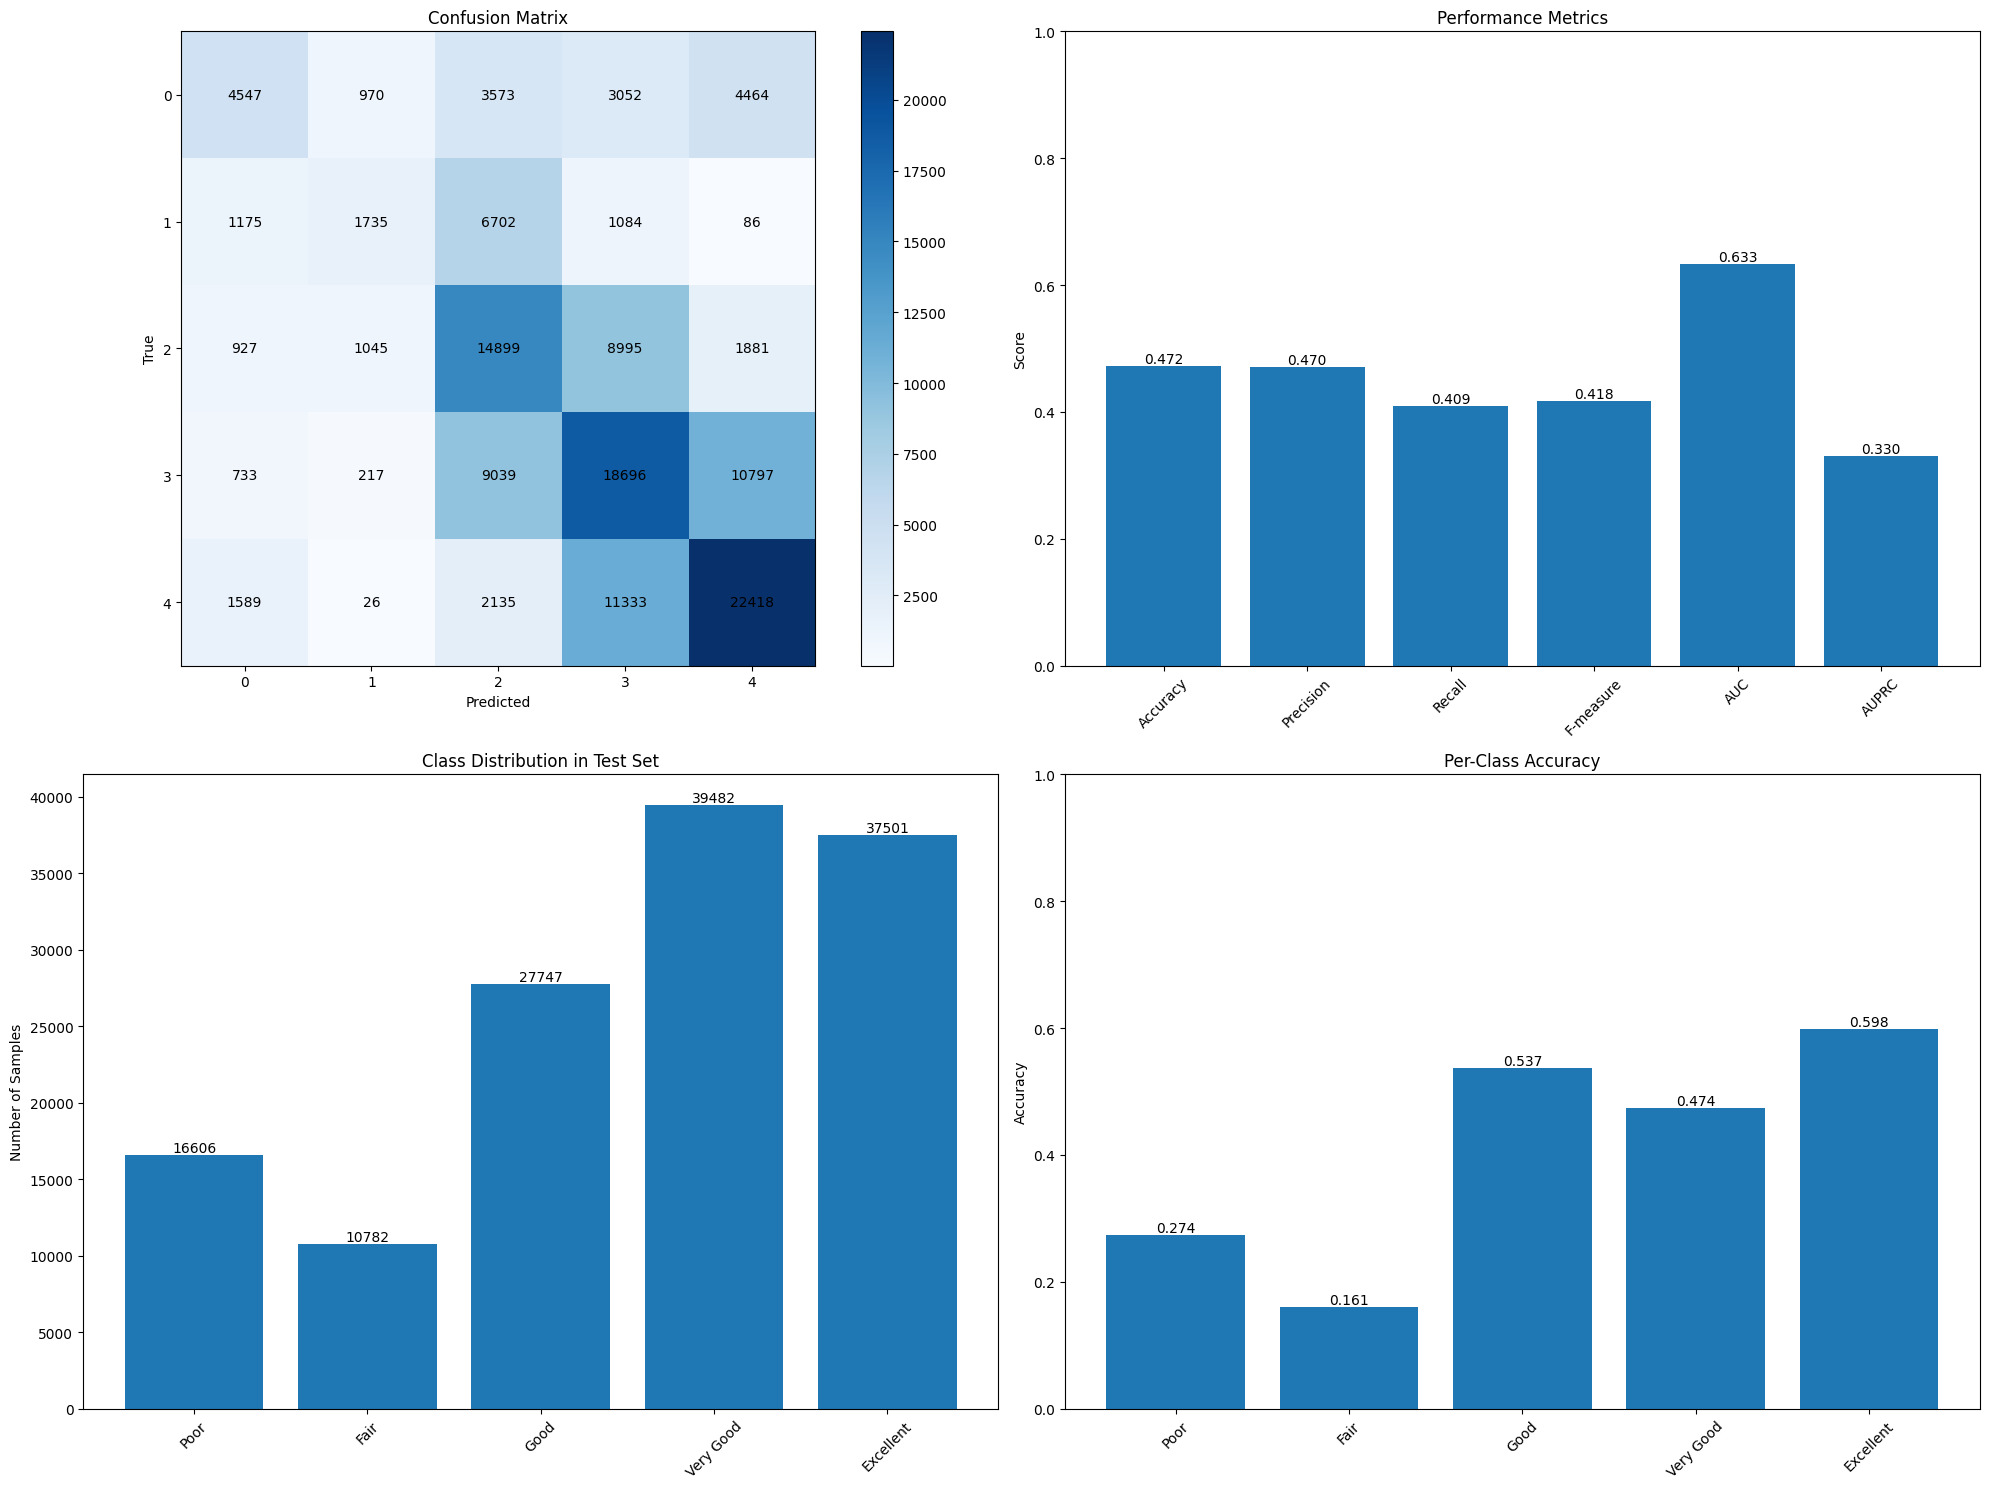

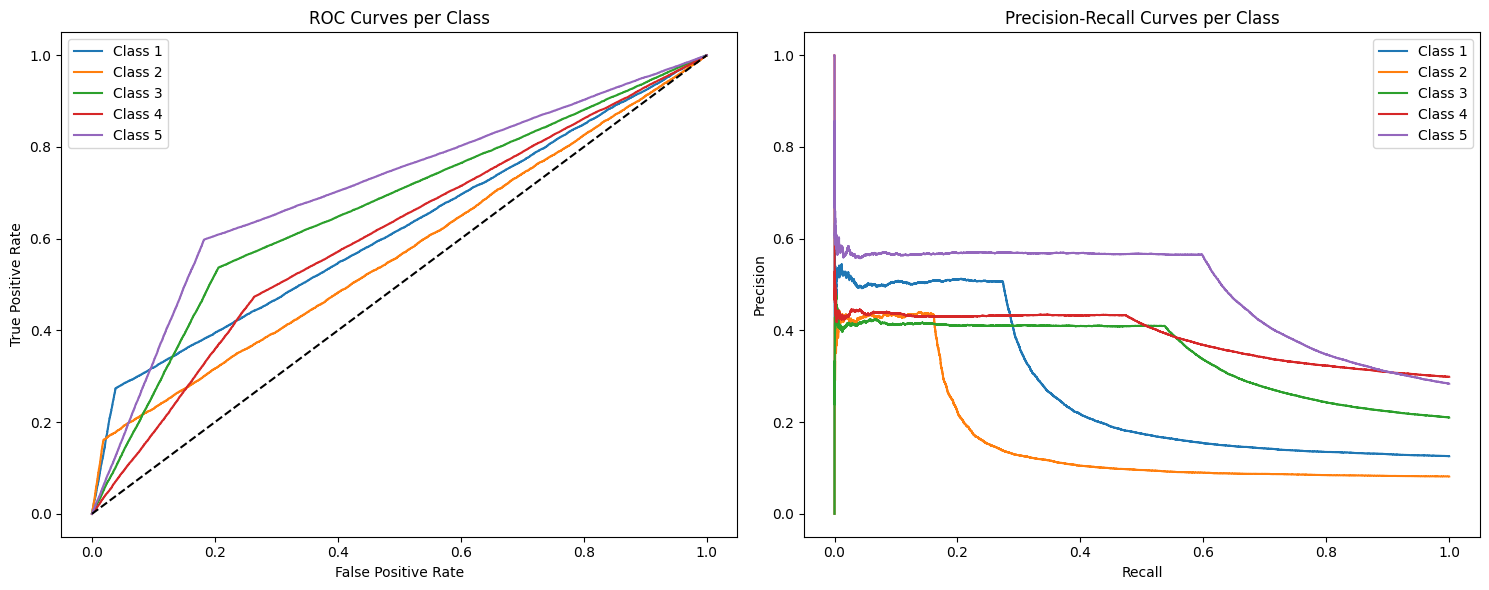

In [4]:
plot_results(y_test, y_pred, metrics)

Reading data...
Preprocessing data...
Preprocessing completed!

Splitting data...
Starting hyperparameter tuning...

Trying parameters: {'max_depth': 8, 'min_samples': 5, 'max_thresholds': 20}
Training decision tree...
Training completed!
Making predictions...
Predictions completed!
Calculating metrics...
Metrics calculation completed!
Accuracy: 0.4875

Trying parameters: {'max_depth': 10, 'min_samples': 10, 'max_thresholds': 30}
Training decision tree...
Training completed!
Making predictions...
Predictions completed!
Calculating metrics...
Metrics calculation completed!
Accuracy: 0.4886

Trying parameters: {'max_depth': 12, 'min_samples': 15, 'max_thresholds': 40}
Training decision tree...
Training completed!
Making predictions...
Predictions completed!
Calculating metrics...
Metrics calculation completed!
Accuracy: 0.4870

Trying parameters: {'max_depth': 15, 'min_samples': 20, 'max_thresholds': 50}
Training decision tree...
Training completed!
Making predictions...
Predictions comp

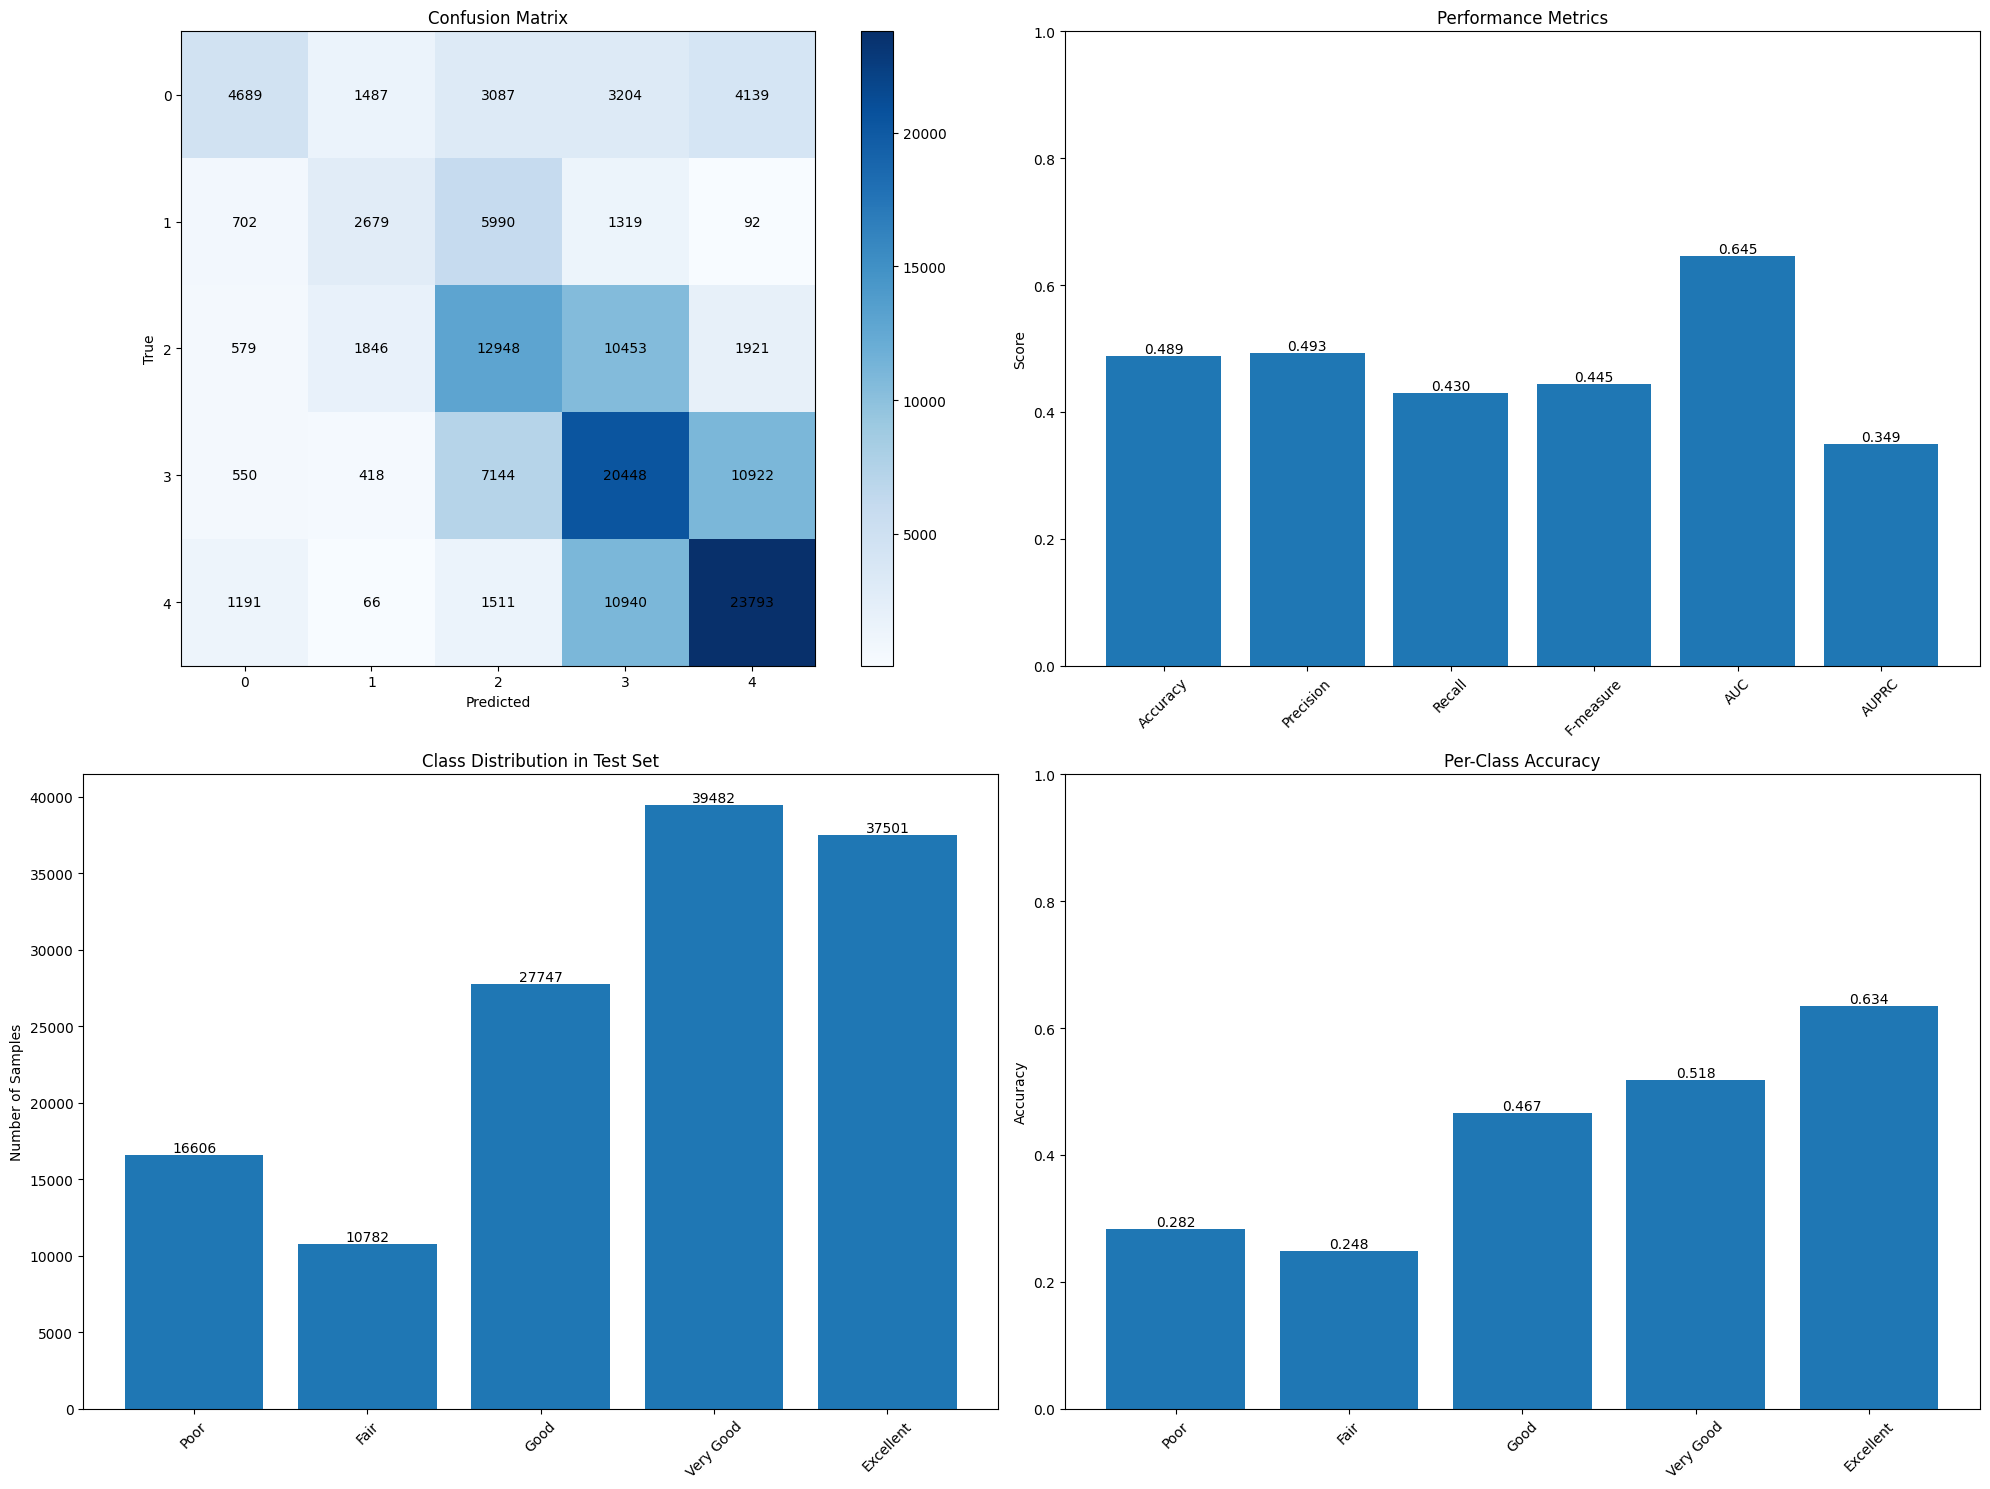

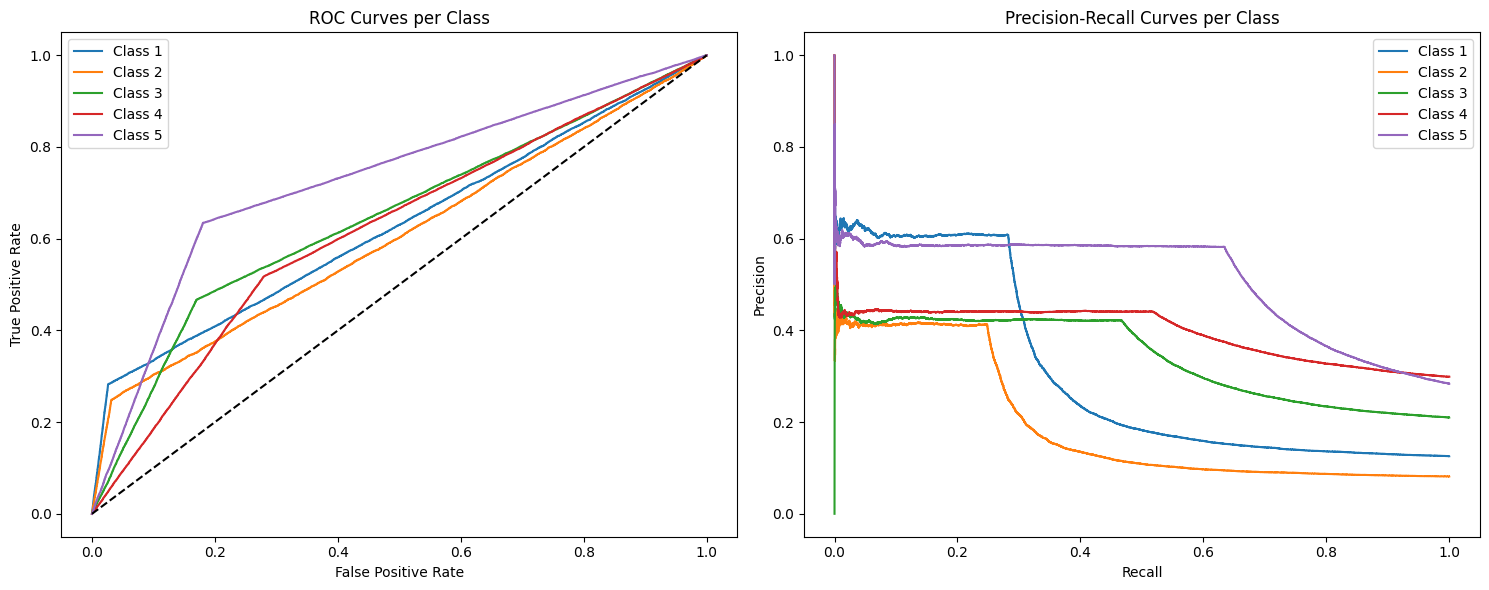

In [5]:
def tune_hyperparameters(X_train, X_test, y_train, y_test):
    """
    Try different hyperparameter combinations and return the best model
    """
    # Define hyperparameter combinations to try
    params_to_try = [
        {'max_depth': 8, 'min_samples': 5, 'max_thresholds': 20},
        {'max_depth': 10, 'min_samples': 10, 'max_thresholds': 30},
        {'max_depth': 12, 'min_samples': 15, 'max_thresholds': 40},
        {'max_depth': 15, 'min_samples': 20, 'max_thresholds': 50}
    ]
    
    best_accuracy = 0
    best_params = None
    best_model = None
    best_predictions = None
    best_metrics = None
    
    print("Starting hyperparameter tuning...")
    
    for params in params_to_try:
        print(f"\nTrying parameters: {params}")
        
        # Train model with current parameters
        clf = DecisionTreeClassifier(**params)
        clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Calculate metrics
        metrics = evaluate_metrics(y_test, y_pred)
        accuracy = metrics['accuracy']
        
        print(f"Accuracy: {accuracy:.4f}")
        
        # Update best model if current is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            best_model = clf
            best_predictions = y_pred
            best_metrics = metrics
    
    print("\nBest parameters found:")
    print(f"max_depth: {best_params['max_depth']}")
    print(f"min_samples: {best_params['min_samples']}")
    print(f"max_thresholds: {best_params['max_thresholds']}")
    print(f"\nBest accuracy: {best_accuracy:.4f}")
    
    return best_model, best_predictions, best_metrics

# Usage:
if __name__ == "__main__":
    # Read and preprocess data
    print("Reading data...")
    data = pd.read_csv("car_prices_cleaned.csv")
    X, y = preprocess_data(data)
    
    # Split data
    print("\nSplitting data...")
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    split = int(0.7 * len(X))
    X_train, X_test = X[indices[:split]], X[indices[split:]]
    y_train, y_test = y[indices[:split]], y[indices[split:]]
    
    # Tune hyperparameters
    best_model, y_pred, metrics = tune_hyperparameters(X_train, X_test, y_train, y_test)
    
    # Plot results
    plot_results(y_test, y_pred, metrics)

Loading and preprocessing data...
Preprocessing data...
Preprocessing completed!

Training decision tree...
Training decision tree...
Training completed!

Calculating SHAP values...

Creating SHAP summary plot...


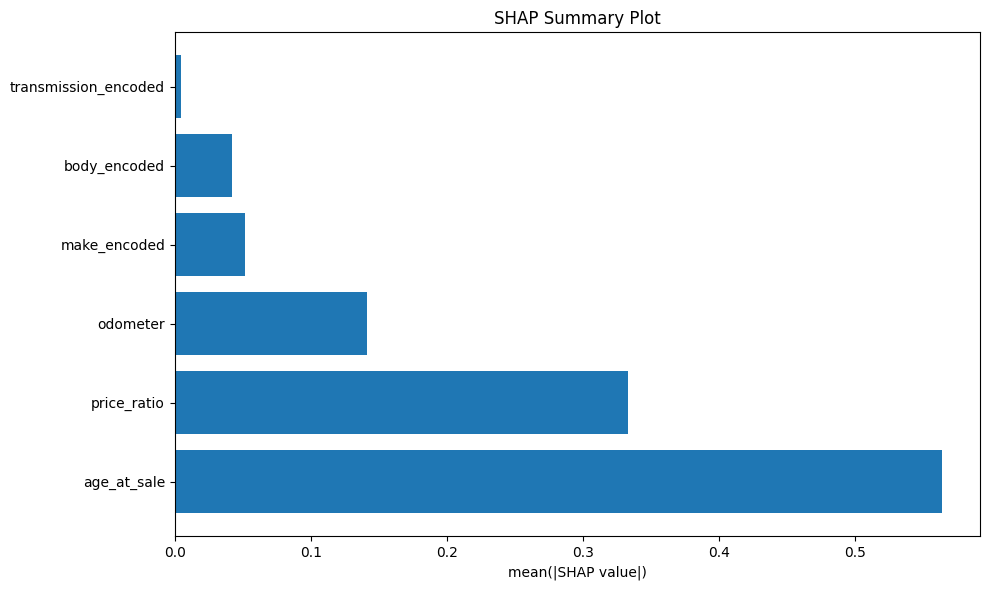


Creating dependence plots for top features...


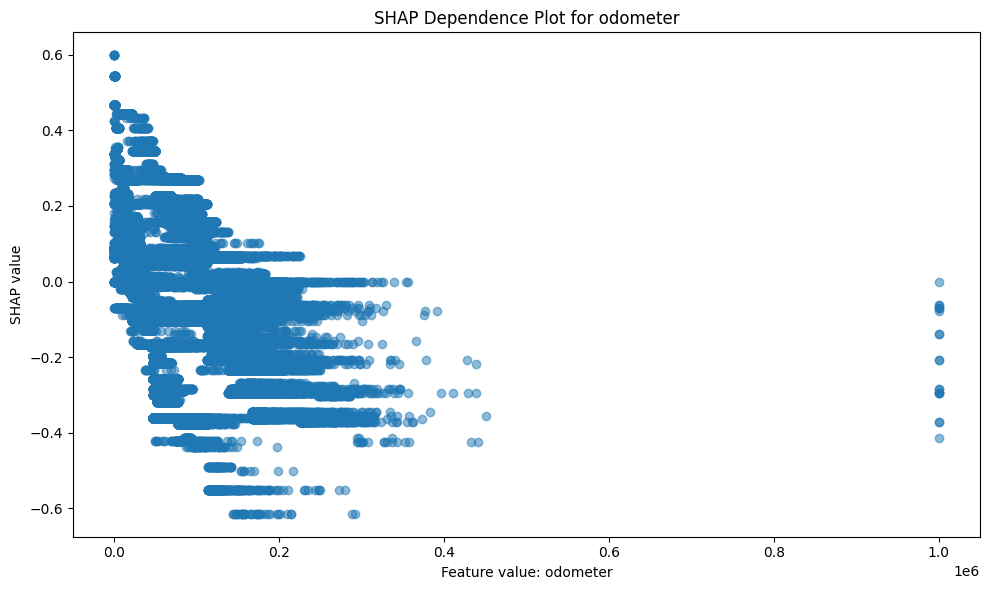

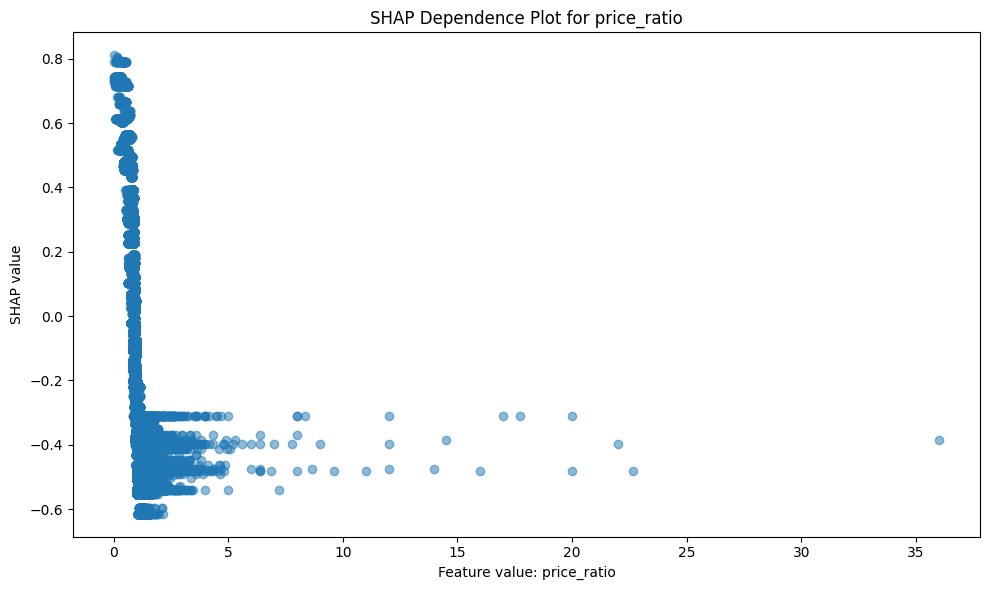

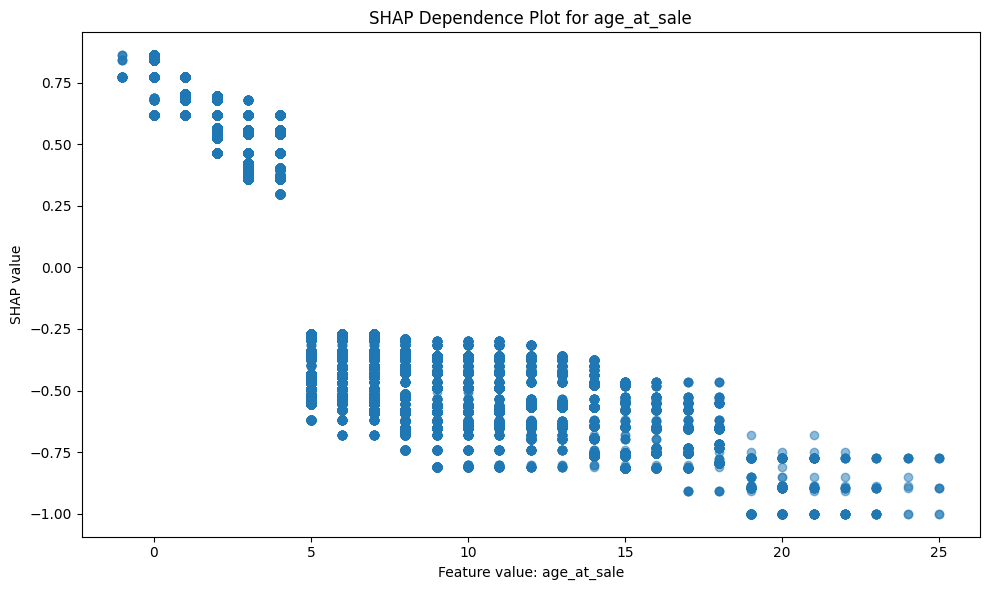


Feature Importance Summary (based on SHAP values):
age_at_sale: 0.5636
price_ratio: 0.3329
odometer: 0.1414
make_encoded: 0.0516
body_encoded: 0.0423
transmission_encoded: 0.0042


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_shap_values(tree, X, feature_names=None):
    """Calculate SHAP values for the decision tree"""
    if feature_names is None:
        feature_names = ['odometer', 'price_ratio', 'make_encoded', 
                        'age_at_sale', 'transmission_encoded', 'body_encoded']
    
    def get_path_through_tree(x, node, path=None):
        """Get path from root to leaf for a single instance"""
        if path is None:
            path = []
        
        if node['is_leaf']:
            return path
        
        feature = node['feature']
        threshold = node['threshold']
        
        if x[feature] <= threshold:
            path.append((feature, threshold, True))
            return get_path_through_tree(x, node['left'], path)
        else:
            path.append((feature, threshold, False))
            return get_path_through_tree(x, node['right'], path)
    
    def calculate_instance_shap(x):
        """Calculate SHAP values for a single instance"""
        path = get_path_through_tree(x, tree.root)
        shap_values = np.zeros(len(feature_names))
        
        for depth, (feature, threshold, went_left) in enumerate(path):
            contribution = 1.0 / (depth + 1)  # Weight based on depth
            if went_left:
                shap_values[feature] += contribution
            else:
                shap_values[feature] -= contribution
        
        return shap_values
    
    # Calculate SHAP values for all instances
    shap_values = np.array([calculate_instance_shap(x) for x in X])
    
    # Normalize SHAP values
    max_abs_shap = np.abs(shap_values).max()
    if max_abs_shap > 0:
        shap_values /= max_abs_shap
    
    return shap_values, feature_names

def plot_shap_summary(shap_values, feature_names, title="SHAP Summary Plot"):
    """Create a summary plot of SHAP values"""
    plt.figure(figsize=(10, 6))
    
    # Calculate mean absolute SHAP value for each feature
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    feature_importance = list(zip(feature_names, mean_abs_shap))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    # Plot
    features, importance = zip(*feature_importance)
    y_pos = np.arange(len(features))
    
    plt.barh(y_pos, importance)
    plt.yticks(y_pos, features)
    plt.xlabel('mean(|SHAP value|)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_shap_dependence(shap_values, X, feature_idx, feature_names):
    """Create a dependence plot for a specific feature"""
    plt.figure(figsize=(10, 6))
    
    feature_name = feature_names[feature_idx]
    feature_shap = shap_values[:, feature_idx]
    feature_value = X[:, feature_idx]
    
    plt.scatter(feature_value, feature_shap, alpha=0.5)
    plt.xlabel(f"Feature value: {feature_name}")
    plt.ylabel("SHAP value")
    plt.title(f"SHAP Dependence Plot for {feature_name}")
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing data...")
    data = pd.read_csv("car_prices_cleaned.csv")
    X, y = preprocess_data(data)
    
    # Split data
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    split = int(0.7 * len(X))
    X_train, X_test = X[indices[:split]], X[indices[split:]]
    y_train, y_test = y[indices[:split]], y[indices[split:]]
    
    # Train model with best hyperparameters
    print("\nTraining decision tree...")
    clf = DecisionTreeClassifier(max_depth=10, min_samples=10, max_thresholds=30)
    clf.fit(X_train, y_train)
    
    # Calculate SHAP values
    print("\nCalculating SHAP values...")
    feature_names = ['odometer', 'price_ratio', 'make_encoded', 
                    'age_at_sale', 'transmission_encoded', 'body_encoded']
    shap_values, feature_names = get_shap_values(clf, X_test, feature_names)
    
    # Plot SHAP summary
    print("\nCreating SHAP summary plot...")
    plot_shap_summary(shap_values, feature_names)
    
    # Plot dependence plots for top 3 features
    print("\nCreating dependence plots for top features...")
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    top_features = np.argsort(mean_abs_shap)[-3:]
    
    for feature_idx in top_features:
        plot_shap_dependence(shap_values, X_test, feature_idx, feature_names)
    
    # Print feature importance summary
    print("\nFeature Importance Summary (based on SHAP values):")
    feature_importance = list(zip(feature_names, mean_abs_shap))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")

In [17]:
0.5636+0.3329+0.1414+0.0516+0.0423+0.0042

1.1360000000000001

In [7]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Custom wrapper to simulate probability output for SHAP compatibility
class DecisionTreeWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, X):
        # Get predictions
        predictions = self.model.predict(X)
        n_classes = len(np.unique(predictions))

        # Convert to probability distribution (one-hot encoding)
        proba = np.zeros((len(X), n_classes))
        for i, pred in enumerate(predictions):
            proba[i, pred - 1] = 1  # Assuming classes are 1-indexed
        return proba

# Wrap the custom model
wrapped_model = DecisionTreeWrapper(clf)

# Apply SHAP explainer
explainer = shap.Explainer(wrapped_model.predict_proba, X_train)
shap_values = explainer(X_test)

# Visualization
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

In [9]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Preprocesare a datelor
def preprocess_data(df):
    """Preprocess the vehicle data"""
    df['saledate'] = pd.to_datetime(df['saledate'].str.split('GMT').str[0].str.strip(),
                                    format='%a %b %d %Y %H:%M:%S')

    # Calculate features
    df['age_at_sale'] = df['saledate'].dt.year - df['year']
    df['price_ratio'] = df['sellingprice'] / df['mmr']
    df['make_encoded'] = pd.Categorical(df['make']).codes
    df['transmission_encoded'] = pd.Categorical(df['transmission']).codes
    df['body_encoded'] = pd.Categorical(df['body']).codes

    # Create feature matrix
    X = df[['odometer', 'price_ratio', 'make_encoded', 'age_at_sale',
            'transmission_encoded', 'body_encoded']].values

    # Create target variable
    def categorize_condition(score):
        if score <= 10:
            return 1  # Poor
        elif score <= 20:
            return 2  # Fair
        elif score <= 30:
            return 3  # Good
        elif score <= 40:
            return 4  # Very Good
        else:
            return 5  # Excellent

    y = df['condition'].apply(categorize_condition).values
    return X, y

# Main execution
if __name__ == "__main__":
    # Citirea datelor
    data = pd.read_csv("car_prices_cleaned.csv")

    # Preprocesarea datelor
    X, y = preprocess_data(data)

    # Împărțirea datelor în train/test (70%-30%)
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    split = int(0.7 * len(X))
    train_idx, test_idx = indices[:split], indices[split:]

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Crearea și antrenarea modelului
    clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42)
    clf.fit(X_train, y_train)

    # Realizarea predicțiilor
    y_pred = clf.predict(X_test)

    # Calcularea metricilor
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Sensitivity per class (recall pe clasă specifică)
    sensitivity_per_class = recall_score(y_test, y_pred, average=None)
    print("\nSensitivity per class (Recall for each class):")
    for i, sensitivity in enumerate(sensitivity_per_class, start=1):
        print(f"Class {i}: {sensitivity:.4f}")

    # Binarizare pentru AUC și AUPRC
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    y_pred_bin = label_binarize(y_pred, classes=np.unique(y))

    # AUC (ROC Curve)
    auc_scores = []
    for i in range(y_test_bin.shape[1]):
        auc_score = roc_auc_score(y_test_bin[:, i], y_pred_bin[:, i])
        auc_scores.append(auc_score)
    mean_auc = np.mean(auc_scores)
    print(f"\nMean AUC (Area Under Curve): {mean_auc:.4f}")

    # AUPRC (Precision-Recall Curve)
    auprc_scores = []
    for i in range(y_test_bin.shape[1]):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
        auprc = auc(recall, precision)
        auprc_scores.append(auprc)
    mean_auprc = np.mean(auprc_scores)
    print(f"Mean AUPRC (Area Under Precision-Recall Curve): {mean_auprc:.4f}")

    # Raportul complet al clasificării
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Rezumăm metricile principale
    print("\nSummary Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


Sensitivity per class (Recall for each class):
Class 1: 0.2760
Class 2: 0.1645
Class 3: 0.4461
Class 4: 0.5297
Class 5: 0.6006

Mean AUC (Area Under Curve): 0.6302
Mean AUPRC (Area Under Precision-Recall Curve): 0.4912

Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.28      0.37     16606
           2       0.43      0.16      0.24     10782
           3       0.41      0.45      0.43     27747
           4       0.42      0.53      0.47     39482
           5       0.56      0.60      0.58     37501

    accuracy                           0.47    132118
   macro avg       0.47      0.40      0.42    132118
weighted avg       0.48      0.47      0.46    132118


Summary Metrics:
Accuracy: 0.4706


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [14]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

class DecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples=2, max_thresholds=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.max_thresholds = max_thresholds
        self.root = None
        
    
        
    def entropy(self, y):
        """Calculate entropy of a node"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    def find_best_split(self, X, y):
        """Optimized best split finder using percentile-based thresholds"""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature in range(n_features):
            # Sample threshold values using percentiles
            feature_values = X[:, feature]
            percentiles = np.linspace(0, 100, self.max_thresholds)
            thresholds = np.percentile(feature_values, percentiles)
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                
                if n_left < self.min_samples or n_right < self.min_samples:
                    continue
                
                # Calculate information gain
                gain = self.entropy(y) - (
                    (n_left / len(y)) * self.entropy(y[left_mask]) +
                    (n_right / len(y)) * self.entropy(y[right_mask])
                )
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        n_samples = len(y)
        
        # Create node
        node = {
            'feature': None,
            'threshold': None,
            'left': None,
            'right': None,
            'value': None,
            'is_leaf': False
        }
        
        # Check stopping criteria
        if (depth >= self.max_depth or 
            n_samples < self.min_samples or 
            len(np.unique(y)) == 1):
            node['is_leaf'] = True
            node['value'] = np.bincount(y).argmax()
            return node
        
        # Find best split
        feature, threshold = self.find_best_split(X, y)
        
        if feature is None:
            node['is_leaf'] = True
            node['value'] = np.bincount(y).argmax()
            return node
        
        # Split the node
        left_mask = X[:, feature] <= threshold
        
        node['feature'] = feature
        node['threshold'] = threshold
        node['left'] = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self.build_tree(X[~left_mask], y[~left_mask], depth + 1)
        
        return node
    
    def fit(self, X, y):
        """Train the decision tree"""
        self.root = self.build_tree(X, y)
        return self
    
    def predict_one(self, x, node=None):
        """Predict class for a single sample"""
        if node is None:
            node = self.root
            
        if node['is_leaf']:
            return node['value']
            
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        return self.predict_one(x, node['right'])
    
    def predict(self, X):
        """Predict classes for multiple samples"""
        predictions = np.array([self.predict_one(x) for x in X])
        return predictions

def preprocess_data(df):
    """Preprocess the vehicle data"""
    # Convert saledate to datetime with proper format
    df['saledate'] = pd.to_datetime(df['saledate'].str.split('GMT').str[0].str.strip(), 
                                  format='%a %b %d %Y %H:%M:%S')
    
    # Calculate features
    df['age_at_sale'] = df['saledate'].dt.year - df['year']
    df['price_ratio'] = df['sellingprice'] / df['mmr']
    df['make_encoded'] = pd.Categorical(df['make']).codes
    df['transmission_encoded'] = pd.Categorical(df['transmission']).codes
    df['body_encoded'] = pd.Categorical(df['body']).codes
    
    # Create feature matrix
    X = df[['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 
            'transmission_encoded', 'body_encoded']].values
    
    # Create target variable
    def categorize_condition(score):
        if score <= 10:
            return 1  # Poor
        elif score <= 20:
            return 2  # Fair
        elif score <= 30:
            return 3  # Good
        elif score <= 40:
            return 4  # Very Good
        else:
            return 5  # Excellent
    
    y = df['condition'].apply(categorize_condition).values
    return X, y

def evaluate_metrics(y_true, y_pred):
    """
    Calculate all evaluation metrics including:
    - Accuracy
    - Precision
    - Recall (Sensitivity)
    - F-measure (F1-score)
    - AUC (Area under ROC curve)
    - AUPRC (Area under Precision-Recall curve)
    """
    metrics = {}
    
    # Basic metrics
    classes = np.unique(y_true)
    n_classes = len(classes)
    
    # Initialize per-class metrics
    precisions = []
    recalls = []  # same as sensitivity
    f1_scores = []  # same as f-measure
    aucs = []
    auprcs = []
    
    # Convert predictions to one-hot encoding for AUC calculation
    y_true_onehot = np.zeros((len(y_true), n_classes))
    y_pred_onehot = np.zeros((len(y_pred), n_classes))
    
    for i, c in enumerate(classes):
        y_true_onehot[:, i] = (y_true == c)
        y_pred_onehot[:, i] = (y_pred == c)
    
    # Calculate metrics for each class
    for c in classes:
        # True positives, false positives, false negatives
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        tn = np.sum((y_true != c) & (y_pred != c))
        
        # Precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precisions.append(precision)
        
        # Recall (Sensitivity)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recalls.append(recall)
        
        # F-measure (F1-score)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
        
        # Calculate ROC curve and AUC
        # For binary classification of current class vs rest
        y_true_binary = (y_true == c).astype(int)
        y_pred_binary = (y_pred == c).astype(float)
        
        # Sort predictions and corresponding true values
        sorted_indices = np.argsort(y_pred_binary)[::-1]
        y_true_binary = y_true_binary[sorted_indices]
        
        # Calculate TPR and FPR at different thresholds
        tpr = np.zeros(len(y_true_binary) + 1)
        fpr = np.zeros(len(y_true_binary) + 1)
        
        for i in range(len(y_true_binary)):
            threshold_tpr = np.sum(y_true_binary[:i+1]) / np.sum(y_true_binary)
            threshold_fpr = np.sum(~y_true_binary.astype(bool)[:i+1]) / np.sum(~y_true_binary.astype(bool))
            tpr[i+1] = threshold_tpr
            fpr[i+1] = threshold_fpr
        
        # Calculate AUC using trapezoid rule
        auc = np.trapezoid(tpr, fpr)
        aucs.append(auc)
        
        # Calculate Precision-Recall curve and AUPRC
        # Sort by prediction scores
        precision_curve = []
        recall_curve = []
        
        for i in range(len(y_true_binary)):
            threshold_tp = np.sum(y_true_binary[:i+1])
            threshold_fp = i + 1 - threshold_tp
            threshold_fn = np.sum(y_true_binary[i+1:])
            
            threshold_precision = threshold_tp / (threshold_tp + threshold_fp) if (threshold_tp + threshold_fp) > 0 else 1
            threshold_recall = threshold_tp / (threshold_tp + threshold_fn) if (threshold_tp + threshold_fn) > 0 else 0
            
            precision_curve.append(threshold_precision)
            recall_curve.append(threshold_recall)
        
        # Calculate AUPRC using trapezoid rule
        auprc = np.trapezoid(precision_curve, recall_curve)
        auprcs.append(auprc)
    
    # Calculate final metrics
    metrics['accuracy'] = np.mean(y_true == y_pred)
    metrics['precision'] = np.mean(precisions)
    metrics['recall'] = np.mean(recalls)
    metrics['sensitivity'] = np.mean(recalls)  # Same as recall
    metrics['f_measure'] = np.mean(f1_scores)
    metrics['auc'] = np.mean(aucs)
    metrics['auprc'] = np.mean(auprcs)
    
    return metrics

def cross_validate(model, X, y, n_splits=5):
    """
    Perform K-Fold Cross-Validation on the model.
    Returns average metrics across all folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_metrics = []

    for train_index, test_index in kf.split(X):
        # Împărțim datele în train/test pentru acest fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Antrenăm modelul pe fold-ul curent
        model.fit(X_train, y_train)

        # Realizăm predicții pe setul de test al acestui fold
        y_pred = model.predict(X_test)

        # Calculăm metricile
        fold_metrics = evaluate_metrics(y_test, y_pred)
        all_metrics.append(fold_metrics)

    # Calculăm media metricilor pe toate foldurile
    avg_metrics = {metric: np.mean([fold[metric] for fold in all_metrics]) for metric in all_metrics[0].keys()}
    return avg_metrics

if __name__ == "__main__":
    # Citirea datelor
    data = pd.read_csv("car_prices_cleaned.csv")

    # Preprocesarea datelor
    X, y = preprocess_data(data)

    # Modelul nostru
    clf = DecisionTreeClassifier(max_depth=5, min_samples=2, max_thresholds=10)

    # Cross-Validation
    print("Performing Cross-Validation...")
    metrics = cross_validate(clf, X, y, n_splits=5)

    # Afișăm metricile calculate
    print("\nAverage Metrics across all folds:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Performing Cross-Validation...

Average Metrics across all folds:
accuracy: 0.4725
precision: 0.4694
recall: 0.4103
sensitivity: 0.4103
f_measure: 0.4198
auc: 0.6364
auprc: 0.3312


## Hyperparameter Optimization (Grid Search)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
}

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2}


## Statistical Analysis (Confidence Intervals & Standard Deviation)

In [22]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

def cross_validate_with_statistics(model, X, y, n_splits=5, confidence=0.95):
    """
    Perform K-Fold Cross-Validation on the model and return statistical analysis of results.
    Computes mean, standard deviation, and confidence intervals for each metric.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_metrics = []

    for train_index, test_index in kf.split(X):
        # Split data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model on the current fold
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate metrics
        fold_metrics = evaluate_metrics(y_test, y_pred)
        all_metrics.append(fold_metrics)

    # Compute statistics for each metric
    metrics_stats = {}
    for metric in all_metrics[0].keys():
        values = [fold[metric] for fold in all_metrics]
        mean = np.mean(values)
        std_dev = np.std(values, ddof=1)
        n = len(values)
        ci_half_width = stats.t.ppf((1 + confidence) / 2., n - 1) * (std_dev / np.sqrt(n))
        ci = (mean - ci_half_width, mean + ci_half_width)
        metrics_stats[metric] = {"Mean": mean, "Standard Deviation": std_dev, "Confidence Interval (95%)": ci}

    return metrics_stats

# Example usage:
# Load data
data = pd.read_csv("car_prices_cleaned.csv")
X, y = preprocess_data(data)

# Define the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5)


# Perform cross-validation with statistical analysis
print("Performing Cross-Validation with Statistical Analysis...")
stats_results = cross_validate_with_statistics(clf, X, y, n_splits=5)

# Display results
for metric, stats in stats_results.items():
    print(f"{metric}:")
    print(f"  Mean: {stats['Mean']:.4f}")
    print(f"  Standard Deviation: {stats['Standard Deviation']:.4f}")
    print(f"  Confidence Interval (95%): {stats['Confidence Interval (95%)']}")


Performing Cross-Validation with Statistical Analysis...
accuracy:
  Mean: 0.4730
  Standard Deviation: 0.0020


KeyError: 'Confidence Interval'

In [23]:
for metric, stats in stats_results.items():
    print(stats)

{'Mean': np.float64(0.4730274924288732), 'Standard Deviation': np.float64(0.0019937514662887704), 'Confidence Interval (95%)': (np.float64(0.4705519230118165), np.float64(0.47550306184592994))}
{'Mean': np.float64(0.47516603086509407), 'Standard Deviation': np.float64(0.002528090391613771), 'Confidence Interval (95%)': (np.float64(0.4720269920416224), np.float64(0.47830506968856573))}
{'Mean': np.float64(0.4080859438850449), 'Standard Deviation': np.float64(0.0031977854517135002), 'Confidence Interval (95%)': (np.float64(0.40411536881567245), np.float64(0.4120565189544173))}
{'Mean': np.float64(0.4080859438850449), 'Standard Deviation': np.float64(0.0031977854517135002), 'Confidence Interval (95%)': (np.float64(0.40411536881567245), np.float64(0.4120565189544173))}
{'Mean': np.float64(0.4201023350111452), 'Standard Deviation': np.float64(0.0022956357347416302), 'Confidence Interval (95%)': (np.float64(0.41725192676632644), np.float64(0.42295274325596394))}
{'Mean': np.float64(0.6348831

In [26]:
for metric, stats in stats_results.items():
    print(f"{metric}:")
    print(f"  Mean: {stats['Mean']:.4f}")
    print(f"  Standard Deviation: {stats['Standard Deviation']:.4f}")
    print(f"  Confidence Interval (95%): {stats['Confidence Interval (95%)']}")

accuracy:
  Mean: 0.4730
  Standard Deviation: 0.0020
  Confidence Interval (95%): (np.float64(0.4705519230118165), np.float64(0.47550306184592994))
precision:
  Mean: 0.4752
  Standard Deviation: 0.0025
  Confidence Interval (95%): (np.float64(0.4720269920416224), np.float64(0.47830506968856573))
recall:
  Mean: 0.4081
  Standard Deviation: 0.0032
  Confidence Interval (95%): (np.float64(0.40411536881567245), np.float64(0.4120565189544173))
sensitivity:
  Mean: 0.4081
  Standard Deviation: 0.0032
  Confidence Interval (95%): (np.float64(0.40411536881567245), np.float64(0.4120565189544173))
f_measure:
  Mean: 0.4201
  Standard Deviation: 0.0023
  Confidence Interval (95%): (np.float64(0.41725192676632644), np.float64(0.42295274325596394))
auc:
  Mean: 0.6349
  Standard Deviation: 0.0025
  Confidence Interval (95%): (np.float64(0.6317673149137625), np.float64(0.6379989930334732))
auprc:
  Mean: 0.3326
  Standard Deviation: 0.0020
  Confidence Interval (95%): (np.float64(0.33010301740458

In [27]:
def display_stats_results(stats_results):
    """
    Nicely formats and displays statistical results.
    """
    print("\n" + "="*50)
    print("   Cross-Validation Statistical Analysis Results")
    print("="*50 + "\n")
    
    for metric, stats in stats_results.items():
        mean = stats['Mean']
        std_dev = stats['Standard Deviation']
        ci = stats['Confidence Interval (95%)']
        
        print(f"📌 {metric.upper()}")
        print(f"   ├ Mean               : {mean:.4f}")
        print(f"   ├ Standard Deviation : {std_dev:.4f}")
        print(f"   └ Confidence Interval (95%): ({ci[0]:.4f}, {ci[1]:.4f})")
        print("-" * 50)
    
# Example usage:
display_stats_results(stats_results)


   Cross-Validation Statistical Analysis Results

📌 ACCURACY
   ├ Mean               : 0.4730
   ├ Standard Deviation : 0.0020
   └ Confidence Interval (95%): (0.4706, 0.4755)
--------------------------------------------------
📌 PRECISION
   ├ Mean               : 0.4752
   ├ Standard Deviation : 0.0025
   └ Confidence Interval (95%): (0.4720, 0.4783)
--------------------------------------------------
📌 RECALL
   ├ Mean               : 0.4081
   ├ Standard Deviation : 0.0032
   └ Confidence Interval (95%): (0.4041, 0.4121)
--------------------------------------------------
📌 SENSITIVITY
   ├ Mean               : 0.4081
   ├ Standard Deviation : 0.0032
   └ Confidence Interval (95%): (0.4041, 0.4121)
--------------------------------------------------
📌 F_MEASURE
   ├ Mean               : 0.4201
   ├ Standard Deviation : 0.0023
   └ Confidence Interval (95%): (0.4173, 0.4230)
--------------------------------------------------
📌 AUC
   ├ Mean               : 0.6349
   ├ Standard Deviatio